# 신용 대출 분석 인공지능 만들기

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

loan_data = pd.read_csv("loanData.csv")
loan_data.tail()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
609,LA001350,Male,22,Yes,NaN,Graduate,No,43,13650,56,0.0,1.0,759,Urban,1,2,4000,26,1
610,LA001357,Male,24,NaN,NaN,Graduate,No,62,3816,41,754.0,1.0,3190,Urban,1,2,2880,30,1
611,LA001760,Male,25,NaN,NaN,Graduate,No,86,4758,52,0.0,1.0,1747,Semiurban,1,2,2844,34,1
612,LA002943,Male,67,No,NaN,Graduate,No,12,2987,2,0.0,0.0,0,Semiurban,1,2,1760,30,0
613,LA002393,Female,44,NaN,NaN,Graduate,No,94,10047,43,0.0,1.0,1181,Semiurban,2,1,3712,22,1


gander, dependents, education 칼럼은 기계가 이해할 수 없는 문자열 형식이다.

이러한 것을 예외처리 하지 않고 처리하면 에러 메세지를 만나게 된다.

시행착오를 줄이기 위해서는 칼럼마다 예외 조항은 없는지, 데이터 형식이 기대한 대로 입력됐는지 확인해야 한다.

In [8]:
# 특정 칼럼의 값 중 중복을 제외한 값을 출력하는 방식
loan_data["dependents"].unique()

array(['3+', '2', '1', '0', nan], dtype=object)

3+ 와 같은 데이터는 인식할 수 없다. 이러한 데이터를 실수형 데이터로 변환해야 한다.

In [10]:
# 데이터의 성별 칼럼을 정수형 데이터로 매핑하는 코드
gendr_mapping = {'Male': 1, 'Female': 0, np.nan: -1}
loan_data = loan_data.replace({'gender': gendr_mapping})

loan_data.head()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
0,LA001250,1,55,Yes,3+,Not Graduate,No,88,4755,51,0.0,0.0,0,Semiurban,3,8,2090,0,0
1,LA001864,1,68,Yes,3+,Not Graduate,No,14,4931,47,0.0,NaN,0,Semiurban,3,7,5376,24,0
2,LA002536,1,43,Yes,3+,Not Graduate,No,56,3095,33,0.0,1.0,1382,Rural,3,5,3390,33,1
3,LA001264,1,22,Yes,3+,Not Graduate,Yes,46,3333,68,2166.0,NaN,0,Semiurban,2,5,2600,36,1
4,LA001384,1,34,Yes,3+,Not Graduate,No,60,2071,60,754.0,1.0,2756,Semiurban,2,5,2820,53,0


In [11]:
# 칼럼 값을 실수형 데이터로 변환하는 코드
gendr_mapping = {'Male': 1, 'Female': 0, np.nan: -1}
married_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
dep_mapping = {'0':0, '1': 1, '2':2, '3+':3, np.nan: -1}
edu_mapping = {'Graduate': 1, 'Not Graduate': 0}
emp_mapping = {'No': 0, 'Yes':1, np.nan: -1}
prop_mapping = {'Urban': 1, 'Rural':3, 'Semiurban':2}

loan_data = loan_data.replace({'married': married_mapping,
                              'dependents': dep_mapping,
                              'education': edu_mapping,
                              'self_employed': emp_mapping,
                              'property_area': prop_mapping})

loan_data.head()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
0,LA001250,1,55,1,3,0,0,88,4755,51,0.0,0.0,0,2,3,8,2090,0,0
1,LA001864,1,68,1,3,0,0,14,4931,47,0.0,NaN,0,2,3,7,5376,24,0
2,LA002536,1,43,1,3,0,0,56,3095,33,0.0,1.0,1382,3,3,5,3390,33,1
3,LA001264,1,22,1,3,0,1,46,3333,68,2166.0,NaN,0,2,2,5,2600,36,1
4,LA001384,1,34,1,3,0,0,60,2071,60,754.0,1.0,2756,2,2,5,2820,53,0


In [14]:
loan_data = loan_data.fillna(-1)
loan_data.isnull().sum()

id                       0
gender                   0
age                      0
married                  0
dependents               0
education                0
self_employed            0
business_type            0
applicant_income         0
applicant_work_period    0
coapplicant_income       0
credit_history           0
credit_amount            0
property_area            0
property_type            0
credit_rate              0
loan_amount              0
loan_term                0
loan_status              0
dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

X = loan_data.loc[:, 'gender':'loan_term']
y = loan_data.loc[:, 'loan_status']

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2, random_state=20)

실습에 사용된 데이터는 각 칼럼이 서로 영향이 적고 이산적이다. 

일반적으로 트리 모형이 이산적인 데이터를 분석하는 데 유리하다고 알려져 있다.

In [16]:
model = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',)

model.fit(x_train, y_train)

[15:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\seong\anaconda3\envs\xai\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, x_test, y_test):
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %.2f%%'%(accuracy * 100.0))
    return accuracy
calculate_accuracy(model, x_test, y_test)

Accuracy: 85.37%


0.8536585365853658

85.37%의 정확도를 보인다.

하지만 이 사실만으로는 모델이 어떻게 학습됐는지 파악할 수 없다.

수치만으로는 이 모델이 어떤 데이터에 취약한지, 어떤 경우에 대출 심사가 빨리 끝날지 알 수 없다.

# XAI 결합하기

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

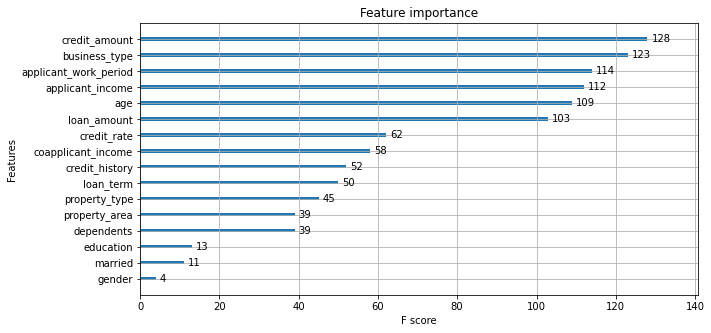

In [18]:
# 피처 중요도를 출력하는 코드
import xgboost
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10, 5
xgboost.plot_importance(model)

피처 중요도는 음의 영향력을 표시하지 않는다.

나이가 적을수록 좋은지, 많을수록 좋은지 피처 중요도로는 대답할 수 없다.

In [23]:
# SHAP 기법을 사용해서 사용자 한 명을 분석하는 코드

import shap

idx = 13

print(x_train.iloc[idx, :])

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap.force_plot(explainer.expected_value,
               shap_values[idx, :],
               x_train.iloc[idx,:])

gender                      1.0
age                        30.0
married                     1.0
dependents                  0.0
education                   1.0
self_employed               0.0
business_type              74.0
applicant_income         1809.0
applicant_work_period      35.0
coapplicant_income       1868.0
credit_history              1.0
credit_amount            3212.0
property_area               1.0
property_type               1.0
credit_rate                 3.0
loan_amount              2520.0
loan_term                  30.0
Name: 498, dtype: float64


이 사용자는 대출 신청이 승인됐다(6.93 > 0).

사용자의 age와 loan_amount가 큰 역할을 했다.

이처럼 SHAP 분석을 사용하면 사용자의 대출 승인 여부를 조목조목 분해할 수 있다.

In [24]:
# SHAP 기법을 사용해서 사용자 한 명을 분석하는 코드

idx = 15

print(x_train.iloc[idx, :])

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap.force_plot(explainer.expected_value,
               shap_values[idx, :],
               x_train.iloc[idx,:])

gender                      1.0
age                        60.0
married                     1.0
dependents                  1.0
education                   1.0
self_employed               0.0
business_type              14.0
applicant_income         6400.0
applicant_work_period      38.0
coapplicant_income       7250.0
credit_history              0.0
credit_amount               0.0
property_area               1.0
property_type               3.0
credit_rate                 7.0
loan_amount              3240.0
loan_term                  28.0
Name: 181, dtype: float64


이 사용자는 대출 신청이 거부됐다(-6.45 < 0).

credit_history와 credit_rate가 큰 역할을 했다.

In [26]:
# 모든 학습 데이터에 대해 설명체 전체를 플롯으로 보여주는 코드

shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, x_train)

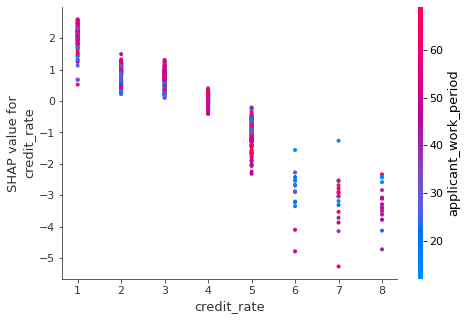

In [27]:
# 신용등급 하나의 피처에 대해 SHAP 영향력을 출력

shap.dependence_plot("credit_rate", shap_values, x_train)

대출 여부가 신용 등급과 느슨한 선형 관계를 갖는다는 것을 보여준다.

예외가 있기는 하지만, 일반적으로 대출은 5등급보다 높을 때 긍정적인 영향을 미치고

그 아래 등급에서는 부정적인 영향을 미친다.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


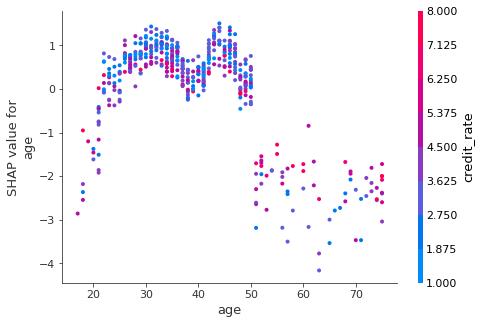

In [28]:
shap.dependence_plot("age", shap_values, x_train)

나이는 모든 신용 등급에 고루 분포돼 있다.

이는 나이가 대출 승인 면에서 신용도만큼 중요하지 않을 것이라는 추론을 뒷받침한다.

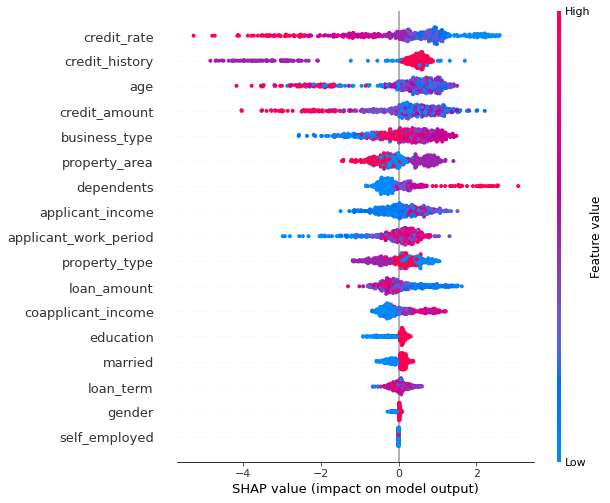

In [29]:
# 모든 피처에 대해 모델에 미치는 영향력 출력
shap.summary_plot(shap_values, x_train)

위 결과에 의하면 기존 대출이 많은 사람이 대출이 없거나 적은 사람보다 대출에 유리하며,

신용 등급이 높은 사람이 대출 승인 가능성이 높다.

또한, 나이가 어릴수록 대출에 유리하며, 비즈니스 업종은 낮은 쪽보다 높은 쪽 분류가 대출에 유리하다.

반면 성별, 대출 기간은 대출 승인에 거의 영향을 미치지 않는 다는 점도 확인할 수 있다.

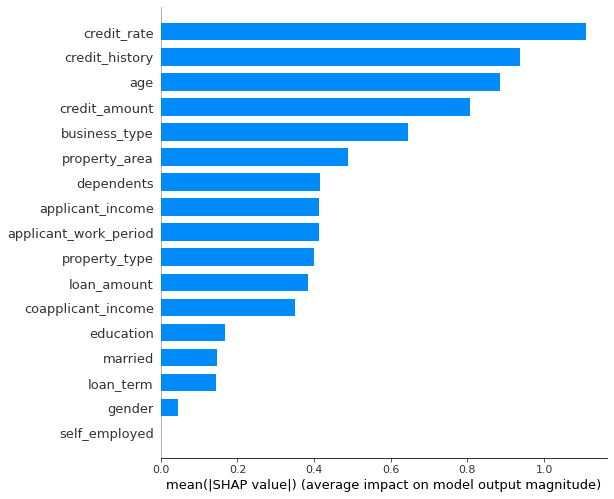

In [30]:
shap.summary_plot(shap_values, x_train, plot_type = 'bar')

위 결과는 피처 중요도 결과와 순서가 다른데, 그 이유는 둘의 계산하는 방식이 다르기 때문이다.

SHAP는 대출 결정 여부에 대한 섀플리 분산이 클수록 영향력이 커진다. 즉, 아웃라이어에 민감하다.

그러나 피처 중요도는 피처 값의 변량으로 측정되기 때문에 극단적 수치가 결과물에 적게 반영된다.

# XAI로 모델 파악하기

피처 중요도와 섀플리 총괄 플롯의 결과에서 applicant_income 항목을 주목해보자.

피처 중요도에서는 대출 여부를 결정하는 데 큰 영향을 미친다고 말한다.

그러나 SHAP에 의하면 그다지 중요하지 않다고 한다.

<br><br>

예를 들면 신용 등급은 수입, 직종, 금융 거래 이력 등 간접적으로 미치는 영향에 의해 변동될 수 있는 항목이다.

피처 중요도는 피처가 서로 독립적일 때 이상적으로 작동하기 때문에

신용 등급 등의 수치가 다소 과소평가됐다고 해석할 수 있다.

<br><br>

SHAP는 대출 신청자의 수입뿐만 아니라 종합적인 가치를 계산하기 때문에

수입이 좋은 사람은 다른 상대적인 피처들이 좋을 가능성이 높다.

따라서 SHAP에서 수입은 그렇게 중요한 요소가 아니며, 오히려 종합적인 금융 지표들의 조화가 중요하다고 판단한다.

# XAI로 모델 개선 근거 마련하기

특정 정보가 대출을 결정하는 데 도움이 된다면 설문 항목을 늘려서 등급 결정에 심혈을 기울어야 한다.

반대로 어떤 질문이 대출 여부에 그다지 영향을 미치지 않는 것으로 파악된다면, 

그 질문을 과감하게 삭제해 비용을 절약해야 한다.

피처 중요도와 SHAP는 학력이 대출 승인 여부를 결정하는 데 그다지 중요하지 않는다고 말한다.

따라서 학력 피처를 삭제하고 모델을 구축할 필요가 있다.

In [31]:
# 대출 심사 데이터에서 학력 피처를 삭제하고 모델을 학습시키는 코드

loan_data = loan_data.drop(columns = 'education')

X = loan_data.loc[:, 'gender': 'loan_term']
y = loan_data.loc[:, 'loan_status']

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2, random_state=20)

model = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',)

model.fit(x_train, y_train)
calculate_accuracy(model, x_test, y_test)

[15:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 85.37%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.8536585365853658

#### 피처를 삭제하거나 추가해도 성능에 변화가 없다면 피처를 삭제하는 것이 왜 중요할까?

대출 신청인은 사전 설문 개수가 많아질수록 이탈할 가능성이 높아지고

질문이 많을수록 그 데이터를 처리하는 비용도 증가한다.

한정된 개수의 피처를 측정하고 효율적으로 스크리닝해야 한다.

**비효율적인 피처를 찾고 삭제하는 일은 중요하다.**

필요 없는 피처를 삭제하면 삭제한 피처 개수만큼 새로운 지표를 발굴하는 데 역량을 더 쏟아부을 수도 있다.

XAI는 모델을 구축하는 데서 끝내지 않고 그것을 더욱 개선하고 발전시키려는 사람들에게 근거 있는 도움을 준다.